In [1]:
import numpy as np
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [2]:
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {
    'vitalsign': "select * from mimiciv_derived.vitalsign;"
                }


db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

vitalsign = dataframes['vitalsign']

print(vitalsign.shape)

INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
vitalsign: select * from mimiciv_derived.vitalsign;



INFO:root:Retrieved vitalsign: (9745500, 15)
INFO:root:DATABASE CONNCETION CLOSED.


(9745500, 15)


In [8]:
# import pickle

# with open("../outputs/vitalsign.pkl", "wb") as f:
#     pickle.dump(vitalsign, f)

# with open("../outputs/vitalsign.pkl", "rb") as f:
#     vitalsign = pickle.load(f)

In [3]:
# vitalsign.to_csv('../outputs/vitalsign.csv', index=False, encoding='utf-8-sig')


In [9]:
vitalsign = pd.read_csv('../outputs/vitalsign.csv')

In [13]:
vitalsign.columns

Index(['subject_id', 'stay_id', 'charttime', 'heart_rate', 'sbp', 'dbp', 'mbp',
       'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'temperature_site', 'spo2', 'glucose'],
      dtype='object')

In [54]:
# datetime 변환
time_cols = ['charttime']
vitalsign = utils.to_datetime(vitalsign, time_cols)
print(vitalsign.shape)

Converted charttime to datetime.
(9745500, 15)


In [55]:
subjectlist1 = pd.read_csv('../outputs/subjectlist1.csv', parse_dates=['admittime','intubationtime','dischtime', 'deathtime','extubationtime','reintubation_eventtime'])
sub1list = subjectlist1 >> select('subject_id','hadm_id','stay_id')
sub1list = sub1list.drop_duplicates(subset='stay_id')   # remove dup
sub1list

,subject_id,hadm_id,stay_id
0,10001884,26184834,37510196
1,10003400,23559586,38383343
2,10004401,27939719,31202136
3,10004401,29988601,32773003
5,10005817,28661809,31316840
...,...,...,...
8995,19995595,21784060,34670930
8997,19997367,20617667,35616526
9000,19999068,21606769,30143796
9001,19999442,26785317,32336619


In [56]:
sub1_vitals = sub1list >> left_join(vitalsign, by=['subject_id','stay_id'])
sub1_vitals

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,10001884,26184834,37510196,2131-01-11 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
1,10001884,26184834,37510196,2131-01-11 04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,100.0,NaN
2,10001884,26184834,37510196,2131-01-11 04:22:00,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001884,26184834,37510196,2131-01-11 04:25:00,NaN,180.0,12.0,46.0,180.0,12.0,46.0,NaN,NaN,NaN,NaN,NaN
4,10001884,26184834,37510196,2131-01-11 05:00:00,60.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,98.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267694,19999840,21033226,38978960,2164-09-17 13:17:00,NaN,NaN,NaN,44.0,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN
2267695,19999840,21033226,38978960,2164-09-17 13:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.0
2267696,19999840,21033226,38978960,2164-09-17 13:20:00,74.0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN
2267697,19999840,21033226,38978960,2164-09-17 13:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.0


In [57]:
sub1_vitals[sub1_vitals.stay_id == 37510196]

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,10001884,26184834,37510196,2131-01-11 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
1,10001884,26184834,37510196,2131-01-11 04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,100.0,NaN
2,10001884,26184834,37510196,2131-01-11 04:22:00,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001884,26184834,37510196,2131-01-11 04:25:00,NaN,180.0,12.0,46.0,180.0,12.0,46.0,NaN,NaN,NaN,NaN,NaN
4,10001884,26184834,37510196,2131-01-11 05:00:00,60.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,98.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,10001884,26184834,37510196,2131-01-20 00:01:00,NaN,147.0,83.0,102.0,147.0,83.0,102.0,NaN,NaN,NaN,NaN,NaN
491,10001884,26184834,37510196,2131-01-20 01:00:00,87.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,68.0,NaN
492,10001884,26184834,37510196,2131-01-20 02:00:00,75.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,45.0,NaN
493,10001884,26184834,37510196,2131-01-20 04:00:00,74.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,53.0,NaN


In [58]:
sub1_vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267699 entries, 0 to 2267698
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   subject_id        int64         
 1   hadm_id           int64         
 2   stay_id           int64         
 3   charttime         datetime64[ns]
 4   heart_rate        float64       
 5   sbp               float64       
 6   dbp               float64       
 7   mbp               float64       
 8   sbp_ni            float64       
 9   dbp_ni            float64       
 10  mbp_ni            float64       
 11  resp_rate         float64       
 12  temperature       float64       
 13  temperature_site  object        
 14  spo2              float64       
 15  glucose           float64       
dtypes: datetime64[ns](1), float64(11), int64(3), object(1)
memory usage: 276.8+ MB


### 결측치

<Axes: >

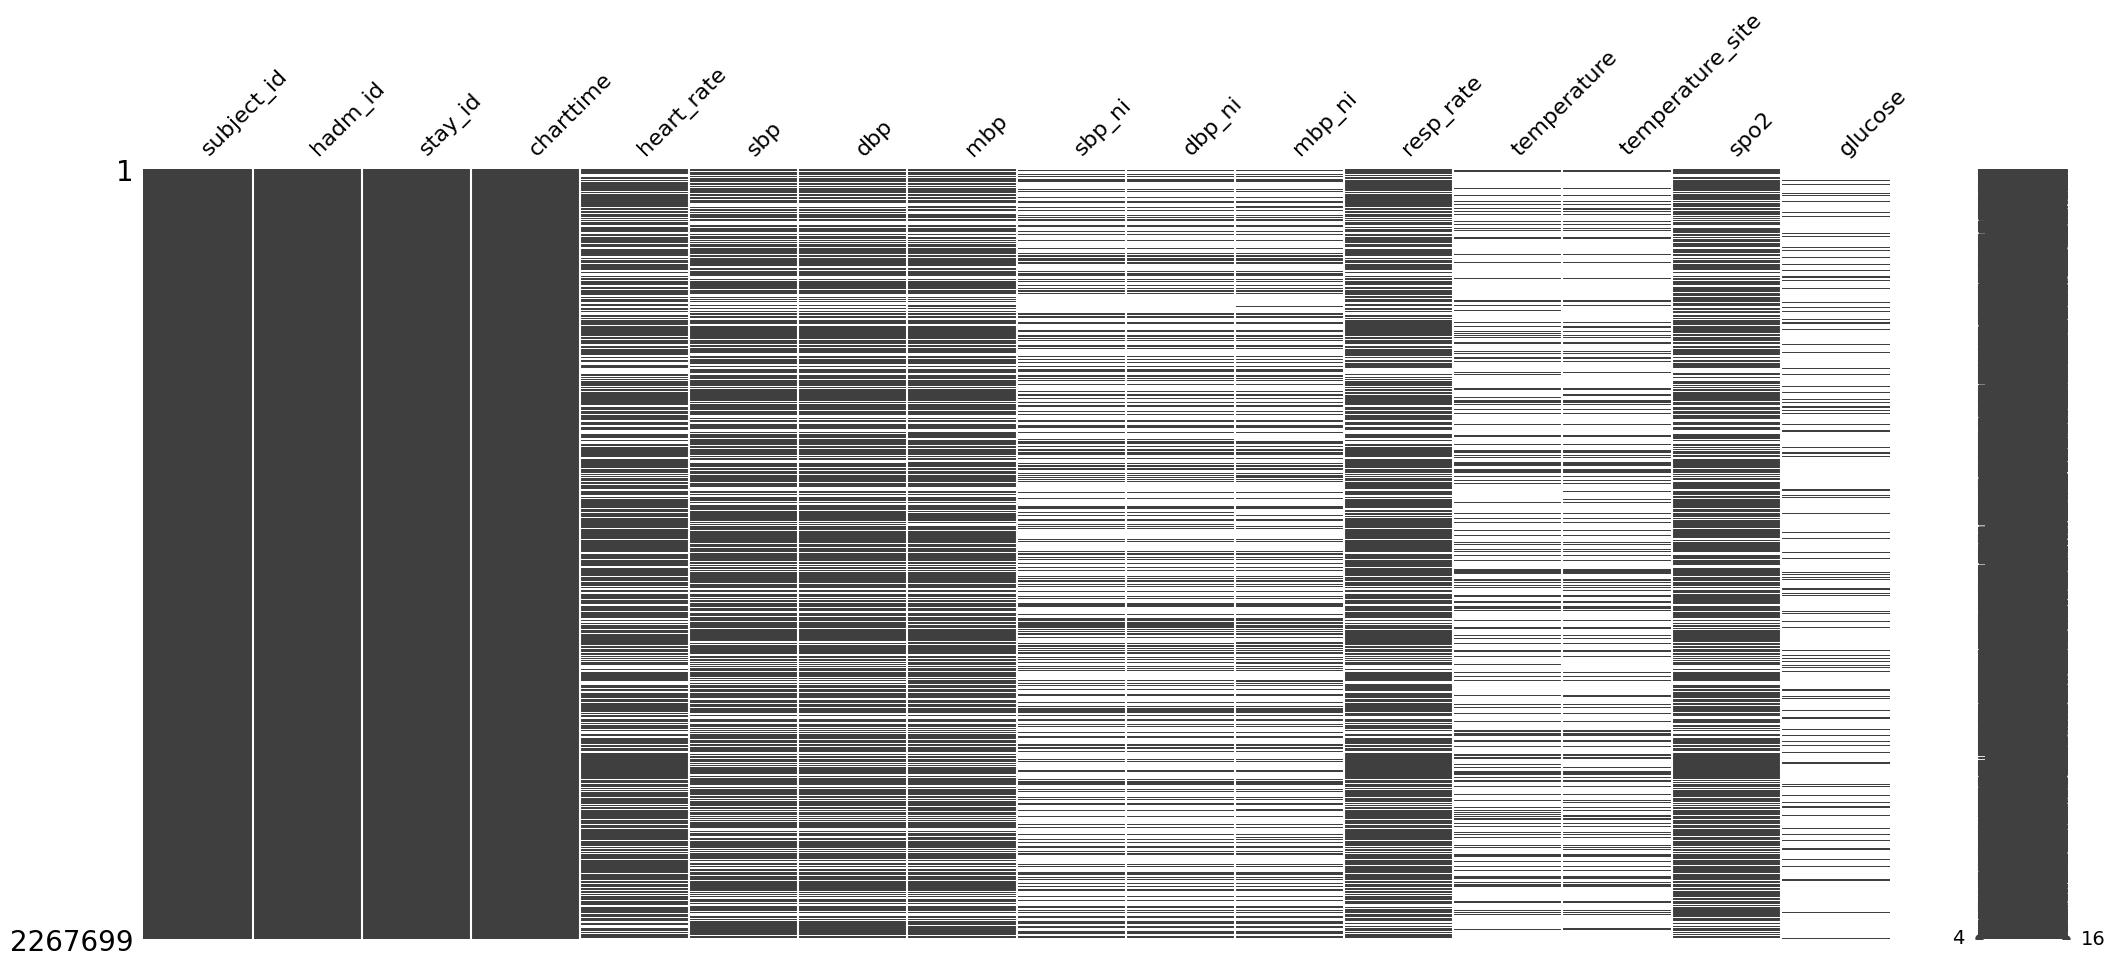

In [22]:
msno.matrix(sub1_vitals)

| Column Name           | Description                                               |
|------------------------|------------------------------------------------------------|
| subject_id            | Unique identifier for the patient                            |
| stay_id               | Unique identifier for the patient's hospital stay            |
| charttime              | Date and time the vital sign was recorded                   |
| heart_rate              | Average heart rate (220045, < 300)                      |
| sbp                   | Average systolic blood pressure (220050, 220179, < 400)     |
| dbp                   | Average diastolic blood pressure (220051, 220180, < 300)    |
| mbp                   | Average mean blood pressure (220052, 220181, 225312, < 300) |
| sbp_ni                 | Average non-invasive systolic blood pressure (220179, < 400) |
| dbp_ni                 | Average non-invasive diastolic blood pressure (220180, < 300) |
| mbp_ni                 | Average non-invasive mean blood pressure (220181, < 300)    |
| resp_rate              | Average respiratory rate (220210, 224690, < 70)           |
| temperature            | Average temperature, converted to Celsius:                       |
|                        |   - Fahrenheit (223761, 70-120, converted)                    |
|                        |   - Celsius (223762, 10-50)                                |
| temperature_site       | Most recent recorded temperature site (224642)                |
| spo2                   | Average SpO2 (peripheral) (220277, 0-100)                 |
| glucose                | Average glucose (225664, 220621, 226537)                     |

**Notes:**

* Potential outliers excluded based on value ranges.
* Temperature might be calculated from overlapping itemids.
* Focuses on specific vital sign ranges based on medical practice standards.


In [71]:
# not null 값 확인
notnull_counts = sub1_vitals.groupby('stay_id').count()
notnull_counts

,subject_id,hadm_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose,time_diff,time_diff_seconds,time_diff_minutes
stay_id,,,,,,,,,,,,,,,,,,
30001148,51,51,51,27,31,31,31,8,8,8,30,10,10,27,14,50,50,50
30001656,39,39,39,29,26,26,26,26,26,26,30,7,7,28,3,38,38,38
30001947,62,62,62,40,39,39,39,14,14,14,41,13,13,40,10,61,61,61
30004144,171,171,171,142,134,134,133,41,41,41,143,27,27,142,16,170,170,170
30006983,1309,1309,1309,1063,1106,1106,1101,158,158,158,1066,256,264,1066,198,1308,1308,1308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39991569,166,166,166,79,74,74,74,74,74,74,79,21,21,76,8,165,165,165
39992167,386,386,386,302,301,301,302,132,132,133,302,84,84,284,52,385,385,385
39992398,24,24,24,20,17,17,17,17,17,17,21,5,5,20,4,23,23,23


In [32]:
notnull_counts.columns

Index(['subject_id', 'hadm_id', 'charttime', 'heart_rate', 'sbp', 'dbp', 'mbp',
       'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'temperature_site', 'spo2', 'glucose'],
      dtype='object')

In [81]:
# stay id 당 지표 count 통계
key_cols = ['heart_rate', 'sbp', 'dbp', 'mbp',
       'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'temperature_site', 'spo2', 'glucose']
print('MEAN')
print(notnull_counts[key_cols].mean())
print('STD')
print(notnull_counts[key_cols].std())
print('MIN')
print(notnull_counts[key_cols].min())
print('MAX')
print(notnull_counts[key_cols].max())

MEAN
heart_rate          218.219195
sbp                 219.772922
dbp                 219.719817
mbp                 219.686350
sbp_ni              112.645001
dbp_ni              112.608768
mbp_ni              112.711796
resp_rate           219.991702
temperature          61.907897
temperature_site     64.187803
spo2                215.516664
glucose              45.000830
dtype: float64
STD
heart_rate          228.856423
sbp                 231.779564
dbp                 231.735803
mbp                 231.682265
sbp_ni              138.098799
dbp_ni              138.078522
mbp_ni              138.064351
resp_rate           234.379295
temperature          71.961870
temperature_site     75.749581
spo2                228.412749
glucose              58.509488
dtype: float64
MIN
heart_rate          0
sbp                 1
dbp                 1
mbp                 1
sbp_ni              0
dbp_ni              0
mbp_ni              0
resp_rate           0
temperature         0
temperature_sit

In [51]:
sub1_vitals

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,10001884,26184834,37510196,2131-01-11 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
1,10001884,26184834,37510196,2131-01-11 04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,100.0,NaN
2,10001884,26184834,37510196,2131-01-11 04:22:00,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001884,26184834,37510196,2131-01-11 04:25:00,NaN,180.0,12.0,46.0,180.0,12.0,46.0,NaN,NaN,NaN,NaN,NaN
4,10001884,26184834,37510196,2131-01-11 05:00:00,60.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,98.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267694,19999840,21033226,38978960,2164-09-17 13:17:00,NaN,NaN,NaN,44.0,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN
2267695,19999840,21033226,38978960,2164-09-17 13:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.0
2267696,19999840,21033226,38978960,2164-09-17 13:20:00,74.0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN
2267697,19999840,21033226,38978960,2164-09-17 13:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.0


In [39]:
notnull_counts[key_cols].std()

heart_rate          228.856423
sbp                 231.779564
dbp                 231.735803
mbp                 231.682265
sbp_ni              138.098799
dbp_ni              138.078522
mbp_ni              138.064351
resp_rate           234.379295
temperature          71.961870
temperature_site     75.749581
spo2                228.412749
glucose              58.509488
dtype: float64

In [38]:
notnull_counts[key_cols].min()

heart_rate          0
sbp                 1
dbp                 1
mbp                 1
sbp_ni              0
dbp_ni              0
mbp_ni              0
resp_rate           0
temperature         0
temperature_site    0
spo2                0
glucose             0
dtype: int64

In [36]:
notnull_counts[key_cols].max()

heart_rate          2587
sbp                 2749
dbp                 2749
mbp                 2766
sbp_ni              1938
dbp_ni              1938
mbp_ni              1936
resp_rate           3752
temperature          853
temperature_site     914
spo2                2619
glucose              781
dtype: int64

sbp dbp mbp 는 stay id 당 최소 1개 씩은 있다. 평균 200개 씩은 있음. (ni 포함)

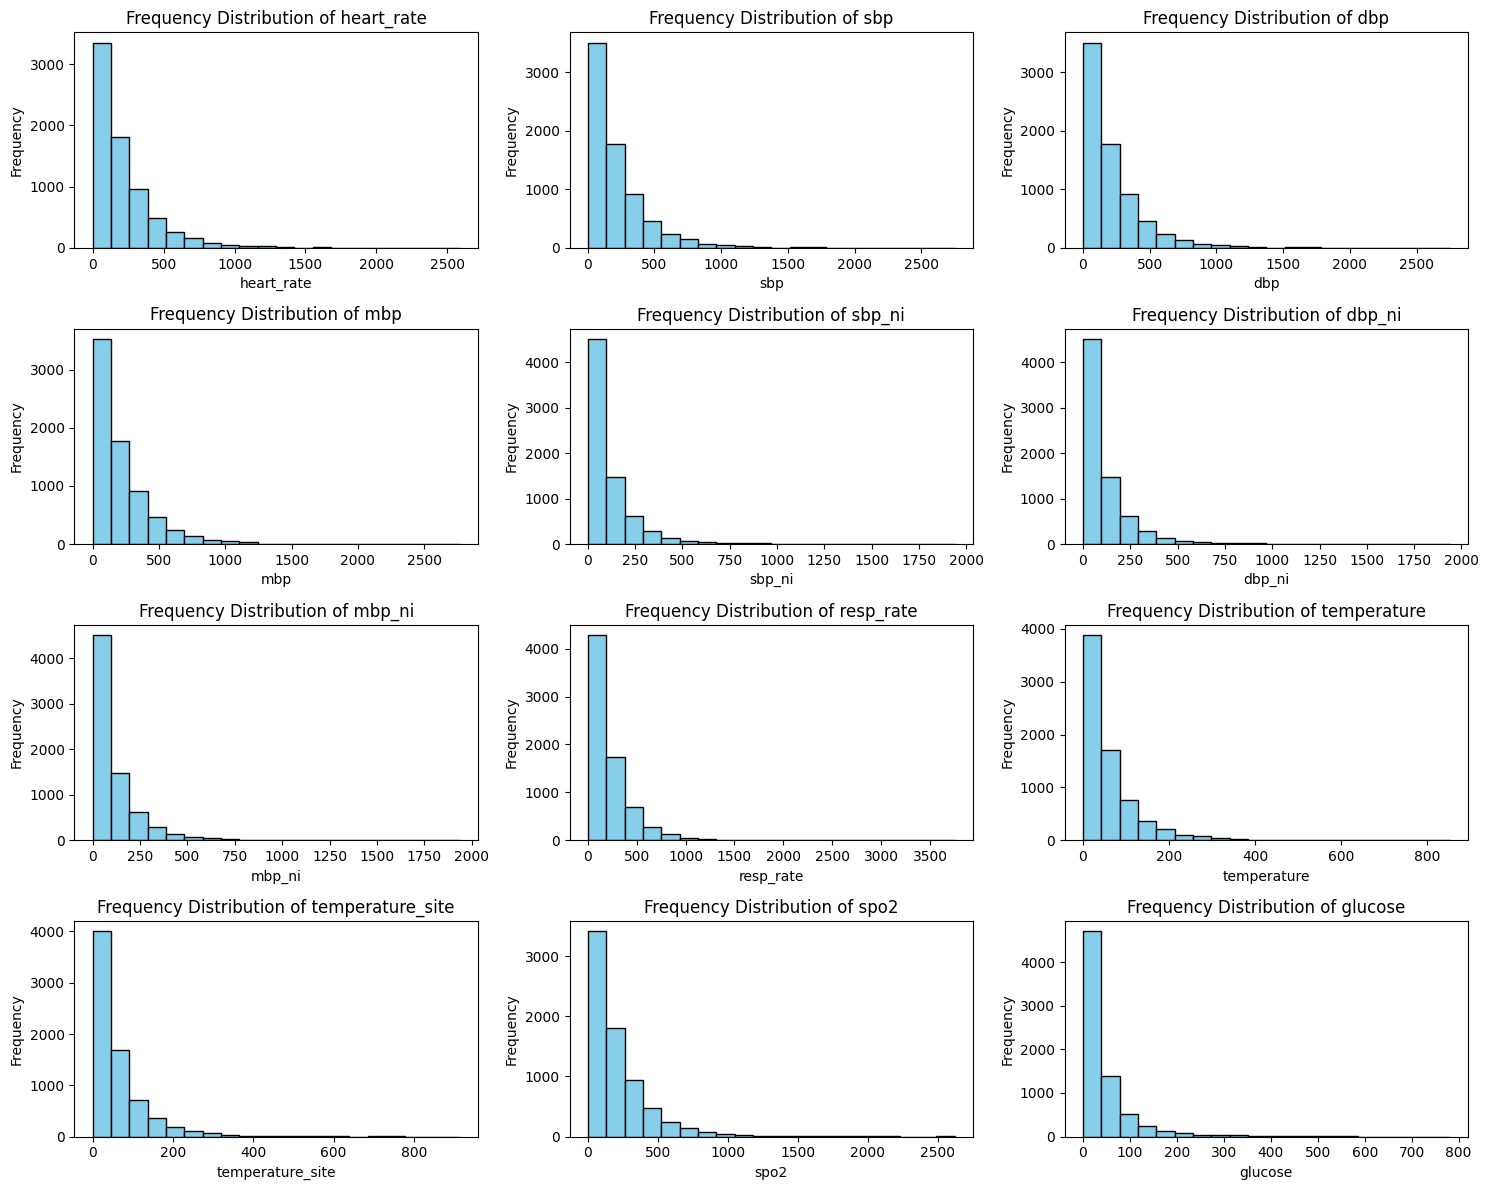

In [50]:
# 칼럼 별로 데이터 빈도 수 분포

# Define the columns for which you want to draw frequency distribution
columns_of_interest = ['heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 
                      'resp_rate', 'temperature', 'temperature_site', 'spo2', 'glucose']

# Determine the number of rows and columns for subplots
num_cols = 3
num_rows = (len(columns_of_interest) + num_cols - 1) // num_cols

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Flatten the axes array if it's more than one dimension
axes = axes.flatten()

# Plotting frequency distribution for each column
for i, column in enumerate(columns_of_interest):
    ax = axes[i]
    notnull_counts[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Frequency Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(False)

# Hide any unused subplots
for i in range(len(columns_of_interest), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [49]:
# 데이터가 아예 없는 건 몇개?
zero_counts = notnull_counts[columns_of_interest].eq(0).sum()
zero_counts

heart_rate           1
sbp                  0
dbp                  0
mbp                  0
sbp_ni              62
dbp_ni              62
mbp_ni              59
resp_rate            1
temperature         40
temperature_site    31
spo2                 5
glucose             49
dtype: int64

In [61]:
# charttime 시간차?

sub1_vitals = sub1_vitals.sort_values(['stay_id', 'charttime'])
sub1_vitals['time_diff'] = sub1_vitals.groupby('stay_id')['charttime'].diff()
sub1_vitals['time_diff_seconds'] = sub1_vitals['time_diff'].dt.total_seconds()   # 비교 위해 변환
sub1_vitals['time_diff_minutes'] = sub1_vitals['time_diff_seconds'] / 60

# Aggregate time_diff
time_diff_stats_minutes = sub1_vitals.groupby('stay_id')['time_diff_minutes'].agg(['mean', 'std', 'min', 'max'])

time_diff_stats_minutes   # 시간차 관련 통계 테이블


,mean,std,min,max
stay_id,,,,
30001148,29.540000,23.385160,1.0,60.0
30001656,40.131579,24.239984,1.0,68.0
30001947,30.491803,24.328737,1.0,61.0
30004144,36.341176,23.441759,1.0,60.0
30006983,45.293578,25.085977,1.0,304.0
...,...,...,...,...
39991569,27.145455,27.039324,1.0,60.0
39992167,37.168831,25.462085,1.0,120.0
39992398,49.565217,30.026997,2.0,148.0


In [66]:
print(time_diff_stats_minutes['mean'].mean())    # 평균 39분 간격으로 측정.
print(time_diff_stats_minutes['mean'].std())  # 편차 23분
print(time_diff_stats_minutes['mean'].min())
print(time_diff_stats_minutes['mean'].max())

39.2506984940705
23.02580963740364
1.4444444444444444
968.6666666666666


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_1727/439646691.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(simulated_data, hist=True, kde=True,


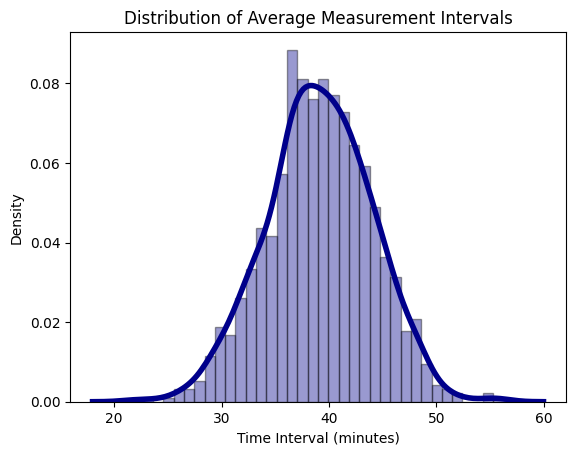

In [69]:
overall_mean = time_diff_stats_minutes['mean'].mean()

# Since this is a single value, for demonstration purposes, we'll create a distribution plot
# by simulating a dataset centered around this value. In a real scenario, you'd plot the actual distribution of data.
# Here's just an example of how to plot if you had a series of values.
simulated_data = np.random.normal(loc=overall_mean, scale=5, size=1000) # Assuming some variability around the mean

# Create the distribution plot
sns.distplot(simulated_data, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Add titles and labels (optional)
plt.title('Distribution of Average Measurement Intervals')
plt.xlabel('Time Interval (minutes)')
plt.ylabel('Density')

plt.show()

In [74]:
# Hadm_id 기준

# not null 값 확인
notnull_counts_hadm = sub1_vitals.groupby(['hadm_id']).count()
notnull_counts_hadm

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose,time_diff,time_diff_seconds,time_diff_minutes
hadm_id,,,,,,,,,,,,,,,,,,
20001361,179,179,179,149,153,153,151,22,22,20,153,38,37,148,14,178,178,178
20004357,110,110,110,93,92,92,92,92,92,92,95,20,20,93,7,109,109,109
20005119,845,845,845,709,730,730,730,198,198,198,725,216,216,713,145,844,844,844
20005241,55,55,55,38,39,39,39,17,17,17,38,3,22,38,28,54,54,54
20014219,861,861,861,523,525,525,525,233,233,233,521,203,179,512,169,860,860,860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991539,898,898,898,630,655,655,652,269,269,277,648,199,183,615,251,897,897,897
29992577,362,362,362,256,251,251,251,218,218,218,264,70,69,224,87,360,360,360
29995505,549,549,549,463,481,481,480,144,144,144,466,121,121,467,81,548,548,548


In [82]:
# stay id 당 지표 count 통계
key_cols = ['heart_rate', 'sbp', 'dbp', 'mbp',
       'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'temperature_site', 'spo2', 'glucose']


print('MEAN')
print(notnull_counts_hadm[key_cols].mean())
print('STD')
print(notnull_counts_hadm[key_cols].std())
print('MIN')
print(notnull_counts_hadm[key_cols].min())
print('MAX')
print(notnull_counts_hadm[key_cols].max())

MEAN
heart_rate          235.724978
sbp                 237.403346
dbp                 237.345981
mbp                 237.309830
sbp_ni              121.681506
dbp_ni              121.642366
mbp_ni              121.753660
resp_rate           237.639677
temperature          66.874216
temperature_site     69.337018
spo2                232.805647
glucose              48.610846
dtype: float64
STD
heart_rate          249.600149
sbp                 252.792565
dbp                 252.742748
mbp                 252.670370
sbp_ni              148.269602
dbp_ni              148.247392
mbp_ni              148.235354
resp_rate           255.125846
temperature          78.462575
temperature_site     82.459565
spo2                248.923793
glucose              63.020224
dtype: float64
MIN
heart_rate          0
sbp                 1
dbp                 1
mbp                 1
sbp_ni              0
dbp_ni              0
mbp_ni              0
resp_rate           0
temperature         0
temperature_sit

In [86]:
sub1_vitals

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose,time_diff,time_diff_seconds,time_diff_minutes
679872,12980335,23552849,30001148,2156-08-30 12:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0,NaT,NaN,NaN
679873,12980335,23552849,30001148,2156-08-30 12:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.0,0 days 00:28:00,1680.0,28.0
679874,12980335,23552849,30001148,2156-08-30 13:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,0 days 00:36:00,2160.0,36.0
679875,12980335,23552849,30001148,2156-08-30 13:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,0 days 00:29:00,1740.0,29.0
679876,12980335,23552849,30001148,2156-08-30 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,Oral,NaN,NaN,0 days 00:03:00,180.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403958,16180713,20178444,39999301,2111-08-19 13:00:00,57.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,94.0,NaN,0 days 01:00:00,3600.0,60.0
1403959,16180713,20178444,39999301,2111-08-19 13:03:00,NaN,134.0,63.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:03:00,180.0,3.0
1403960,16180713,20178444,39999301,2111-08-19 14:00:00,64.0,120.0,72.0,88.0,NaN,NaN,NaN,18.0,NaN,NaN,95.0,NaN,0 days 00:57:00,3420.0,57.0
1403961,16180713,20178444,39999301,2111-08-19 14:25:00,NaN,225.0,154.0,174.0,225.0,154.0,174.0,NaN,NaN,NaN,NaN,NaN,0 days 00:25:00,1500.0,25.0


In [92]:
sub1_vitals.groupby(['subject_id'])['stay_id'].nunique().max()

8

In [89]:
# how many stay id per hadm id?

sub1_vitals.groupby(['hadm_id'])['stay_id'].nunique().max()

4